In [1]:
import polars as pl
from openai import OpenAI
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA





In [ ]:

client = OpenAI(api_key="<API KEY>")
df = pl.scan_csv('../../data/clean/rotten_tomatoes_movie_details_clean.csv').collect()


In [ ]:


def get_embeddings_batched(text_list, model="text-embedding-3-small", batch_size=2000):
    all_embeddings = []
    

    for i in range(0, len(text_list), batch_size):
        batch = text_list[i : i + batch_size]
        
        try:
           
            response = client.embeddings.create(input=batch, model=model)

            batch_embeddings = [item.embedding for item in response.data]
            all_embeddings.extend(batch_embeddings)
            print(f"Processed batch {i} to {i + len(batch)}")
            
        except Exception as e:
            print(f"Error at index {i}: {e}")
            break
            
    return all_embeddings

In [ ]:

print(f"Cleaning {df.height} movies...")

df_full_clean = df.with_columns(
    pl.when(pl.col("description").str.strip_chars().str.len_chars() == 0)
    .then(pl.lit("No description"))
    .otherwise(pl.col("description"))
    .fill_null("No description")
    .alias("description")
)


full_texts = df_full_clean["description"].to_list()
print(f"Ready to send {len(full_texts)} movies to OpenAI.")


full_vectors = get_embeddings_batched(full_texts, batch_size=2000)
end_time = time.time()


if len(full_vectors) == len(full_texts):
    print(f"Success! Generated {len(full_vectors)} vectors in {round(end_time - start_time, 2)} seconds.")
    

    df_final = df_full_clean.with_columns(
        pl.Series(name="embedding", values=full_vectors)
    )

    df_final.write_parquet("rotten_tomatoes_embedded.parquet")
    print("SAVED! File: 'rotten_tomatoes_embedded.parquet'")
    
else:
    print(f"Warning: Data mismatch. Sent {len(full_texts)} but got {len(full_vectors)} vectors.")

Cleaning 17661 movies...
Ready to send 17661 movies to OpenAI.
Processed batch 0 to 2000
Processed batch 2000 to 4000
Processed batch 4000 to 6000
Processed batch 6000 to 8000
Processed batch 8000 to 10000
Processed batch 10000 to 12000
Processed batch 12000 to 14000
Processed batch 14000 to 16000
Processed batch 16000 to 17661
Success! Generated 17661 vectors in 48.51 seconds.
SAVED! File: 'rotten_tomatoes_embedded.parquet'


In [92]:
df

rotten_tomatoes_link,title,description,release_year,embedding
str,str,str,i64,list[f64]
"""m/1074467-in_love_and_war""","""In Love and War""","""In 1918, 18-year-old Ernest He…",1996,"[-0.045627, 0.041834, … -0.002253]"
"""m/flipped""","""Flipped""","""When they meet in second grade…",2010,"[-0.024885, -0.018686, … -0.002076]"
"""m/dark_crimes""","""Dark Crimes""","""A hard-boiled detective become…",2018,"[-0.010771, -0.00484, … -0.022413]"
"""m/blackway""","""Go With Me""","""A vengeful young woman recruit…",2016,"[0.003664, 0.047893, … -0.027877]"
"""m/1014804-neighbors""","""Neighbors""","""Earl Keese (John Belushi) live…",1981,"[-0.003444, 0.059283, … -0.03641]"
…,…,…,…,…
"""m/bronson""","""Bronson""","""In this drama based on a true …",2009,"[-0.018718, 0.045026, … 0.02371]"
"""m/sausage_party""","""Sausage Party""","""Life is good for all the food …",2016,"[-0.008627, 0.038652, … -0.006783]"
"""m/bad_lieutenant_port_of_call_…","""Bad Lieutenant: Port of Call N…","""Terence McDonagh (Nicolas Cage…",2009,"[-0.010807, 0.065879, … -0.00764]"


Calculating Davies-Bouldin Index (Lower is better)...
k=2 | DBI: 6.7908
k=3 | DBI: 5.8785
k=4 | DBI: 5.5870
k=5 | DBI: 5.6121
k=6 | DBI: 5.6231
k=7 | DBI: 5.5730
k=8 | DBI: 5.4245
k=9 | DBI: 4.9503
k=10 | DBI: 5.0685
k=11 | DBI: 4.9118
k=12 | DBI: 4.9932
k=13 | DBI: 5.1673
k=14 | DBI: 4.9964
k=15 | DBI: 5.1519
k=16 | DBI: 5.0979
k=17 | DBI: 5.0946
k=18 | DBI: 4.9529
k=19 | DBI: 5.1332
k=20 | DBI: 4.9089


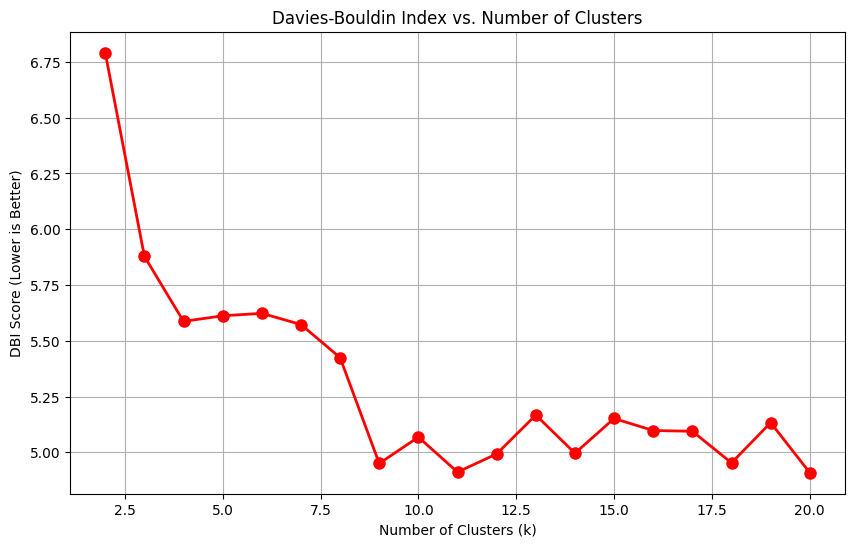

The optimal number of clusters according to DBI is: 20


In [ ]:

k_range = range(2, 21)
db_scores = []

print("Calculating Davies-Bouldin Index (Lower is better)...")

for k in k_range:

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=3)
    labels = kmeans.fit_predict(matrix)
    
    score = davies_bouldin_score(matrix, labels)
    db_scores.append(score)
    
    print(f"k={k} | DBI: {score:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(k_range, db_scores, 'r-o', linewidth=2, markersize=8)
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DBI Score (Lower is Better)')
plt.grid(True)
plt.show()


best_k = k_range[db_scores.index(min(db_scores))]
print(f"The optimal number of clusters according to DBI is: {best_k}")

In [ ]:

k = 9
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(matrix)

df = df.with_columns(pl.Series(name="cluster", values=clusters))


print(f"--- Sample Movies from {k} Clusters ---")

for i in range(k):
    print(f"\nCluster {i}:")
    sample = df.filter(pl.col("cluster") == i).sample(10)
    
    for title in sample["title"]:
        print(f"  • {title}")

--- Sample Movies from 9 Clusters ---

Cluster 0:
  • England Is Mine
  • Rebel in the Rye
  • The World's Fastest Indian
  • Altina
  • Untouchable
  • Love Hunter
  • Wal-Mart: The High Cost of Low Price
  • Bright Lights: Starring Carrie Fisher and Debbie Reynolds
  • Harold and Lillian: A Hollywood Love Story
  • Streetlight Harmonies

Cluster 1:
  • The Lonely Island Presents: The Unauthorized Bash Brothers Experience
  • Enter the Anime
  • Sacred Stage - The Mariinsky Theater
  • Belzebuth
  • The Sentence
  • Demons 2: The Nightmare Returns
  • Pay 2 Play: Democracy's High Stakes
  • Here and Now (Blue Night)
  • QA special Event 02
  • John Leguizamo's Latin History For Morons

Cluster 2:
  • Swept From the Sea
  • Smiley Face
  • The Prisoner of Zenda
  • Match
  • Queen Christina
  • Far and Away
  • My Son the Fanatic
  • The Comedians
  • Damsel
  • The Girl From Monaco

Cluster 3:
  • Badland
  • Alexander the Great
  • The Stalking Moon
  • Mutiny on the Bounty
  • Consp

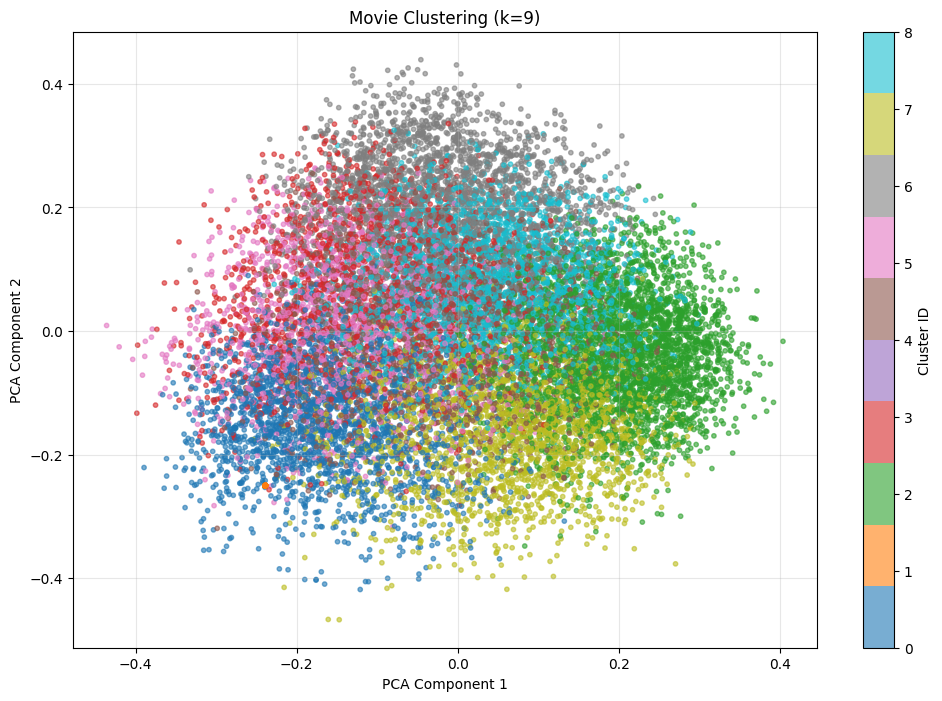

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
vis_dims = pca.fit_transform(matrix)


plt.figure(figsize=(12, 8))
scatter = plt.scatter(vis_dims[:, 0], vis_dims[:, 1], 
                      c=clusters, cmap='tab10', s=10, alpha=0.6)

plt.colorbar(scatter, label="Cluster ID")
plt.title(f"Movie Clustering (k={k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(alpha=0.3)
plt.show()

In [ ]:


df = pl.read_parquet("rotten_tomatoes_embedded.parquet")
all_vectors = np.stack(df["embedding"].to_numpy())


list_1 = [
    "The Matrix", "Alien", "Blade Runner", "The Dark Knight", "Gladiator",
    "Toy Story", "Shrek", "The Lion King", "Titanic", "Solo: A Star Wars Story"
]
list_2 = [
    "The Notebook", "Pride and Prejudice", "La La Land", "Crazy Rich Asians", 
    "Pretty Woman", "Notting Hill", "Love Actually", "The Fault in Our Stars", 
    "A Star Is Born", "Me Before You"
]
list_3 = [
    "The Conjuring", "The Exorcist", "Insidious", "Get Out", 
    "Paranormal Activity", "It Follows", "The Witch", "Hereditary", 
    "A Quiet Place", "Saw"
]
list_4 = [
    "Pulp Fiction", "Fight Club", "The Godfather", "Taxi Driver", 
    "There Will Be Blood", "Moonlight", "Lady Bird", 
    "Eternal Sunshine of the Spotless Mind", "Her", "Whiplash"
]
list_5 = [
    "Frozen", "Moana", "Finding Nemo", "Despicable Me", "Paddington 2", 
    "How to Train Your Dragon", "Zootopia", "Inside Out", "Coco", "The Incredibles"
]


themes = [
    "Epic/Blockbuster",
    "Romantic / Love Stories",
    "Horror / Thriller",
    "Film Buff / Indie Drama",
    "Kids / Family"
]

all_lists = [list_1, list_2, list_3, list_4, list_5]


for i, history in enumerate(all_lists):
    theme_name = themes[i]
    print(f"\n--- {theme_name} ---")
    

    history_df = df.filter(pl.col("title").is_in(history))
    if history_df.height == 0: continue

    user_vector = np.stack(history_df["embedding"].to_numpy()).mean(axis=0).reshape(1, -1)

    scores = cosine_similarity(user_vector, all_vectors).flatten()
    sorted_idx = scores.argsort()[::-1]
    
    seen = set(history)
    count = 0
    for idx in sorted_idx:
        title = df["title"][int(idx)]
        if title not in seen:
            print(f"{scores[idx]:.4f} | {title}")
            count += 1
            if count >= 5: break


--- Epic/Blockbuster ---
0.6101 | Blade Runner: The Final Cut
0.5959 | Star Wars: The Force Awakens
0.5882 | Star Wars: Episode VI - Return of the Jedi
0.5852 | Regarding Henry
0.5807 | In the Name of the King: A Dungeon Siege Tale

--- Romantic / Love Stories ---
0.6744 | Playing by Heart
0.6694 | The Dish & the Spoon
0.6691 | Love the Hard Way
0.6657 | A Four Letter Word
0.6609 | Two Lovers

--- Horror / Thriller ---
0.7155 | Lovely Molly
0.7031 | Marrowbone
0.7027 | Lights Out
0.6952 | Paranormal Activity 4
0.6943 | The Conjuring 2

--- Film Buff / Indie Drama ---
0.6714 | The Salton Sea
0.6586 | Light Sleeper
0.6564 | Sin City
0.6519 | 21 Grams
0.6477 | The Informers

--- Kids / Family ---
0.6280 | The Florida Project
0.6280 | Nim's Island
0.6096 | Ice Age: Continental Drift
0.6069 | Hoodwinked Too! Hood vs. Evil
0.6040 | The Little Mermaid


In [ ]:

df_reviews = pl.read_csv("../../data/clean/rotten_tomatoes_critic_reviews_clean.csv")
df_movies = pl.read_parquet("rotten_tomatoes_embedded.parquet")

df_data = (
    df_reviews
    .filter(pl.col("review_score_numeric").is_not_null())
    .join(df_movies, on="rotten_tomatoes_link", how="inner")
)


all_vectors = np.stack(df_movies["embedding"].to_numpy())
all_titles = df_movies["title"].to_list()
all_links = df_movies["rotten_tomatoes_link"].to_list()

def recommend_weighted(critic_name, top_k=30):
    history = df_data.filter(pl.col("critic_name") == critic_name)
    if history.height < 5: return

    vectors = np.stack(history["embedding"].to_numpy())
    scores = history["review_score_numeric"].to_numpy()

    weights = ((scores - 2.5) / 2.5).reshape(-1, 1)
    

    user_vector = np.sum(vectors * weights, axis=0).reshape(1, -1)
    

    sims = cosine_similarity(user_vector, all_vectors).flatten()
    

    seen_links = set(history["rotten_tomatoes_link"])
    top_indices = sims.argsort()[::-1]
    
    print(f"--- Weighted Recommendations for {critic_name} ---")
    count = 0
    for idx in top_indices:
        if all_links[int(idx)] not in seen_links:
            print(f"{sims[idx]:.4f} | {all_titles[idx]}")
            count += 1
            if count >= top_k: break


top_critic = df_reviews["critic_name"].value_counts().head(1)[0, "critic_name"]
recommend_weighted(top_critic)

--- Weighted Recommendations for Lawrence Toppman ---
0.5892 | The Piano
0.5737 | Cloud Atlas
0.5732 | The Deep End
0.5728 | Labor Day
0.5708 | The Theory of Flight
0.5706 | Infinitely Polar Bear
0.5650 | The Ballad of Jack and Rose
0.5634 | What We Did on Our Holiday
0.5631 | Feast of Love
0.5631 | A Little Princess
0.5614 | Synecdoche, New York
0.5611 | The Winter Guest
0.5603 | Atonement
0.5590 | The Nines
0.5582 | The Governess
0.5580 | Proof
0.5574 | The Painted Veil
0.5572 | You're Not You
0.5559 | The Book of Love
0.5555 | The Dish & the Spoon
0.5551 | Happy Endings
0.5530 | King of California
0.5507 | Breathe In
0.5504 | Side Effects
0.5503 | Nim's Island
0.5496 | Zathura
0.5496 | Fierce People
0.5494 | The Intended
0.5488 | Molly
0.5488 | A Rumor of Angels


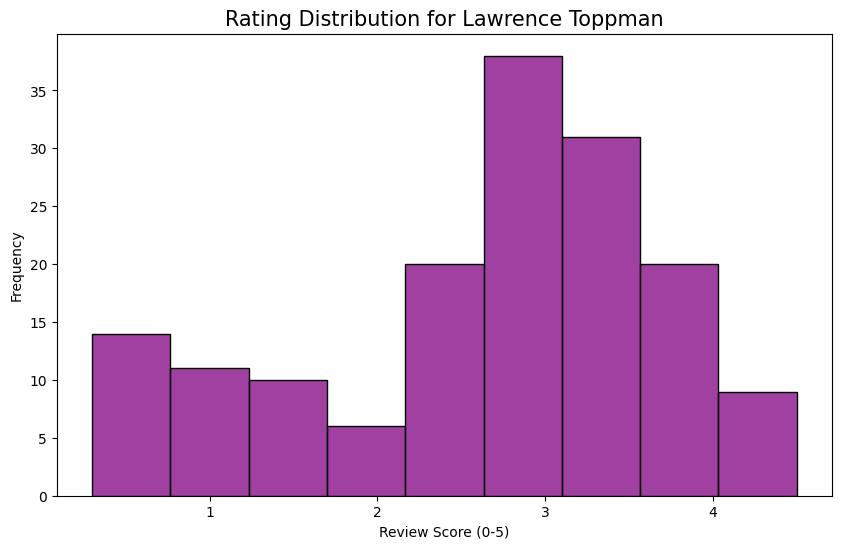

In [89]:
#show all the ratings of the top critic in a histogram
critic_history = df_data.filter(pl.col("critic_name") == top_critic)
ratings = critic_history["review_score_numeric"].to_list()  
plt.figure(figsize=(10, 6))
sns.histplot(ratings, bins=9, kde=False, color='purple', edgecolor='black')
plt.title(f'Rating Distribution for {top_critic}', fontsize=15)
plt.xlabel('Review Score (0-5)')
plt.ylabel('Frequency')
plt.show()

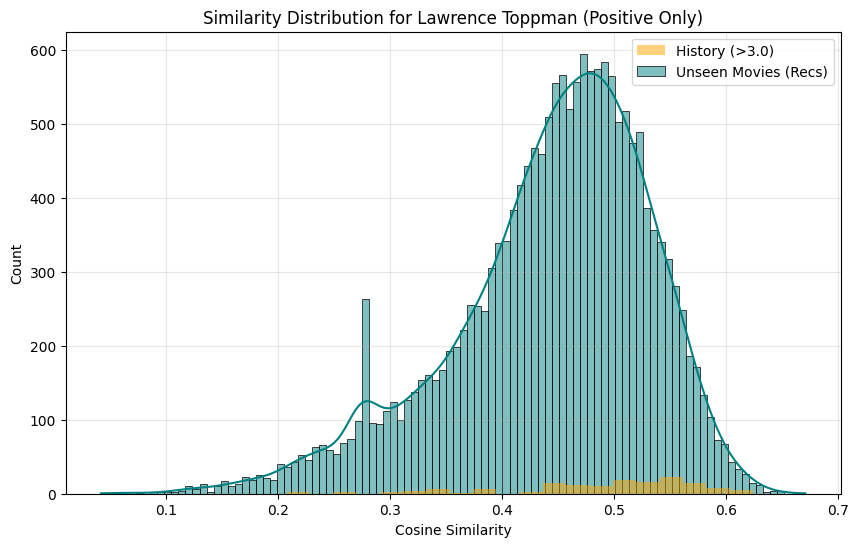

In [ ]:

def plot_critic_distribution(critic_name, threshold=3.0):
    # Filter for positive reviews only
    history = df_data.filter(
        (pl.col("critic_name") == critic_name) & 
        (pl.col("review_score_numeric") > threshold)
    )
    
    # Calculate User Vector (Simple Mean of Favorites)
    user_vector = np.stack(history["embedding"].to_numpy()).mean(axis=0).reshape(1, -1)
    
    # Get all similarities
    sims = cosine_similarity(user_vector, all_vectors).flatten()
    
    # Separate Seen (History) vs Unseen (Recommendations)
    seen_links = set(df_data.filter(pl.col("critic_name") == critic_name)["rotten_tomatoes_link"])
    mask = [link not in seen_links for link in all_links]
    
    unseen_scores = sims[mask]
    seen_scores = sims[~np.array(mask)]
    

    plt.figure(figsize=(10, 6))
    sns.histplot(unseen_scores, bins=100, kde=True, color='teal', label='Unseen Movies (Recs)')
    plt.hist(seen_scores, bins=20, color='orange', alpha=0.5, label='History (>3.0)')
    
    plt.title(f'Similarity Distribution for {critic_name} (Positive Only)')
    plt.xlabel('Cosine Similarity')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_critic_distribution(top_critic)

C:\Users\farim\AppData\Local\Temp\ipykernel_21160\1448022770.py:6: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  df_data.group_by("critic_name").count()


Validating on 345 critics (Random Split)...
Global Average Correlation: -0.0451


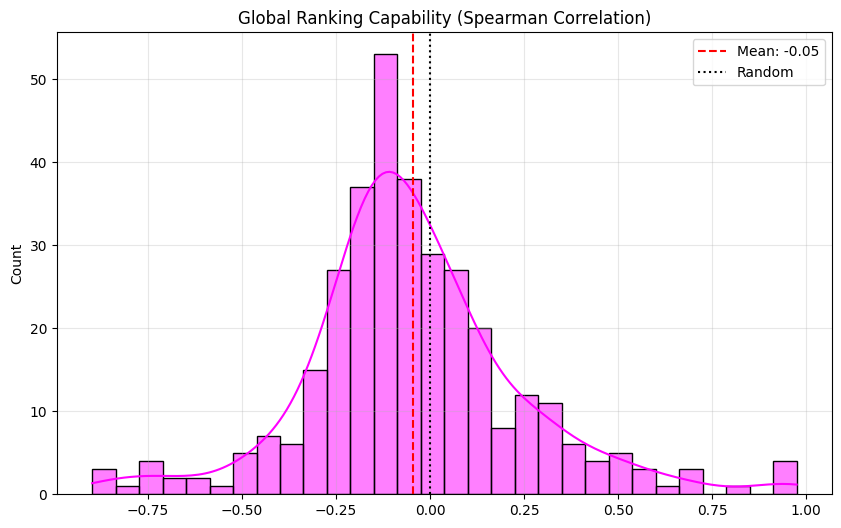

In [ ]:
from scipy.stats import spearmanr

def validate_spearman(min_reviews=20, split_ratio=0.8, seed=42):
    # Filter valid critics
    valid_critics = (
        df_data.group_by("critic_name").count()
        .filter(pl.col("count") >= min_reviews)
        .select("critic_name").to_series().to_list()
    )
    
    print(f"Validating on {len(valid_critics)} critics (Random Split)...")
    correlations = []
    
    for critic in valid_critics:
        # Get and Shuffle History
        history = df_data.filter(pl.col("critic_name") == critic)
        history = history.sample(fraction=1.0, shuffle=True, seed=seed)
        
        # Split Train/Test
        n = history.height
        cut = int(n * split_ratio)
        train, test = history.head(cut), history.tail(n - cut)
        
        if test.height < 5: continue
            
        # Build Profile (Movies > 3.0)
        good_train = train.filter(pl.col("review_score_numeric") > 3.0)
        if good_train.height == 0: continue
            
        user_vector = np.stack(good_train["embedding"].to_numpy()).mean(axis=0).reshape(1, -1)
        
        # Predict
        test_vecs = np.stack(test["embedding"].to_numpy())
        preds = cosine_similarity(user_vector, test_vecs).flatten()
        actuals = test["review_score_numeric"].to_numpy()
        
        # Calculate Spearman
        if np.std(actuals) > 0:
            corr, _ = spearmanr(preds, actuals)
            if not np.isnan(corr): correlations.append(corr)

    # Visualization
    if not correlations: return
    avg_corr = np.mean(correlations)
    
    print(f"Global Average Correlation: {avg_corr:.4f}")
    
    plt.figure(figsize=(10, 6))
    sns.histplot(correlations, bins=30, kde=True, color='magenta', edgecolor='black')
    plt.axvline(avg_corr, color='red', linestyle='--', label=f'Mean: {avg_corr:.2f}')
    plt.axvline(0.0, color='black', linestyle=':', label='Random')
    plt.title('Global Ranking Capability (Spearman Correlation)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

validate_spearman()

In [ ]:
import polars as pl
import numpy as np


df_meta = pl.read_csv("../../data/clean/movies_merged.csv")

df_vectors = pl.read_parquet("rotten_tomatoes_embedded.parquet")


df_combined = df_meta.join(df_vectors, on="rotten_tomatoes_link", how="inner")


individual_genres = (
    df_combined
    .select(pl.col("lm_genre").fill_null("Unknown").str.split("|").alias("genre_list"))
    .explode("genre_list")
    .group_by("genre_list")
    .count()
    .sort("count", descending=True)
)

print("--- Top 20 Individual Genres ---")
print(individual_genres.head(20))





C:\Users\farim\AppData\Local\Temp\ipykernel_20600\1219298136.py:23: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()


--- Top 20 Individual Genres ---
shape: (20, 2)
┌────────────────────┬───────┐
│ genre_list         ┆ count │
│ ---                ┆ ---   │
│ str                ┆ u32   │
╞════════════════════╪═══════╡
│ Drama              ┆ 6844  │
│ Comedy             ┆ 4517  │
│ Unknown            ┆ 3251  │
│ Thriller           ┆ 2966  │
│ Romance            ┆ 2128  │
│ …                  ┆ …     │
│ Animation          ┆ 487   │
│ Musical            ┆ 462   │
│ Western            ┆ 302   │
│ (no genres listed) ┆ 165   │
│ IMAX               ┆ 161   │
└────────────────────┴───────┘


C:\Users\farim\AppData\Local\Temp\ipykernel_20600\678104425.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf, x="count", y="genre_list", palette="viridis")


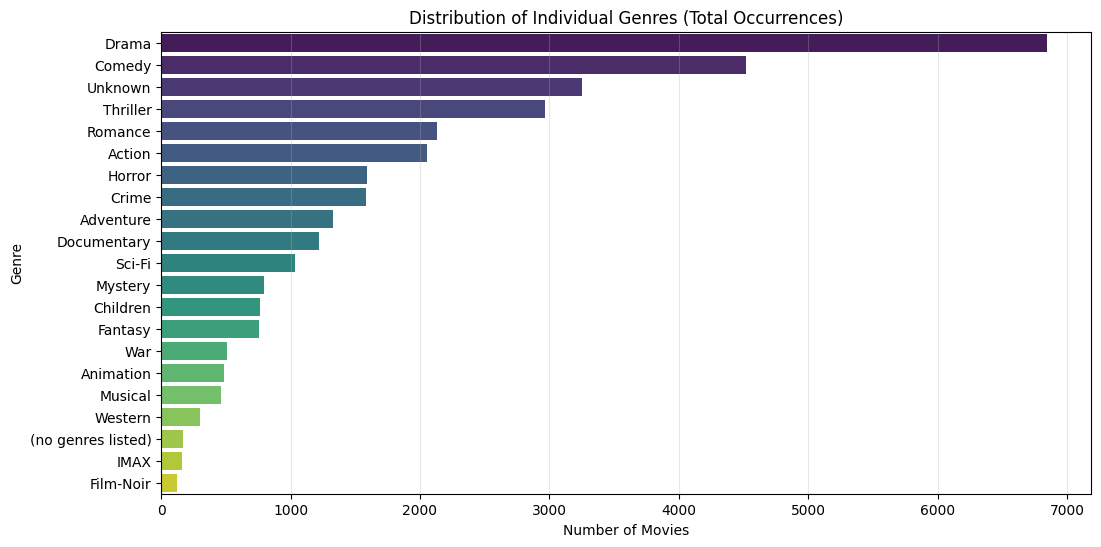

In [9]:
pdf = individual_genres.to_pandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=pdf, x="count", y="genre_list", palette="viridis")
plt.title("Distribution of Individual Genres (Total Occurrences)")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.grid(axis='x', alpha=0.3)
plt.show()

C:\Users\farim\AppData\Local\Temp\ipykernel_20600\4235944970.py:15: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()


--- Top 10 Primary Genres ---
shape: (10, 2)
┌───────────────┬───────┐
│ primary_genre ┆ count │
│ ---           ┆ ---   │
│ str           ┆ u32   │
╞═══════════════╪═══════╡
│ Drama         ┆ 3920  │
│ Comedy        ┆ 3548  │
│ Unknown       ┆ 3251  │
│ Action        ┆ 2058  │
│ Documentary   ┆ 1121  │
│ Horror        ┆ 842   │
│ Crime         ┆ 841   │
│ Adventure     ┆ 732   │
│ Children      ┆ 273   │
│ Animation     ┆ 241   │
└───────────────┴───────┘


C:\Users\farim\AppData\Local\Temp\ipykernel_20600\4235944970.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


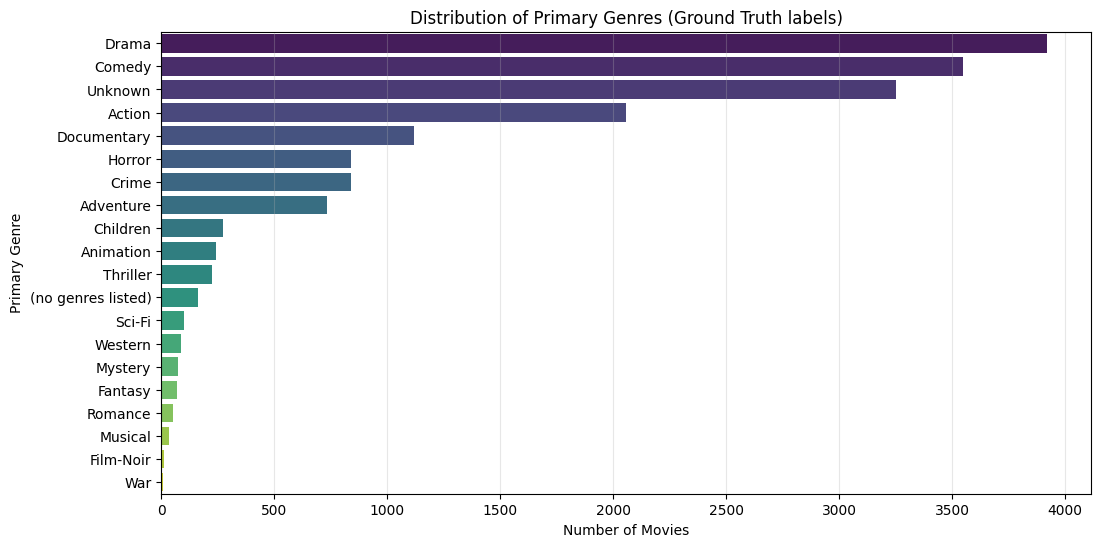

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns


df_primary = df_combined.with_columns(
    pl.col("lm_genre").str.split("|").list.get(0).fill_null("Unknown").alias("primary_genre")
)

genre_counts = (
    df_primary
    .group_by("primary_genre")
    .count()
    .sort("count", descending=True)
)

print("--- Top 10 Primary Genres ---")
print(genre_counts.head(10))


pdf = genre_counts.to_pandas()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=pdf, 
    x="count", 
    y="primary_genre", 
    palette="viridis"
)

plt.title("Distribution of Primary Genres (Ground Truth labels)")
plt.xlabel("Number of Movies")
plt.ylabel("Primary Genre")
plt.grid(axis='x', alpha=0.3)
plt.show()

Calculating DBI scores for k=2 to 20...
k=2: 6.5633 | k=3: 5.8663 | k=4: 5.5868 | k=5: 5.5657 | k=6: 5.5376 | k=7: 5.4904 | k=8: 5.5513 | k=9: 5.6808 | k=10: 5.1987 | k=11: 4.9427 | k=12: 5.1626 | k=13: 5.1822 | k=14: 5.2096 | k=15: 5.1402 | k=16: 5.0777 | k=17: 5.0148 | k=18: 5.0112 | k=19: 5.0308 | k=20: 4.9880 | 

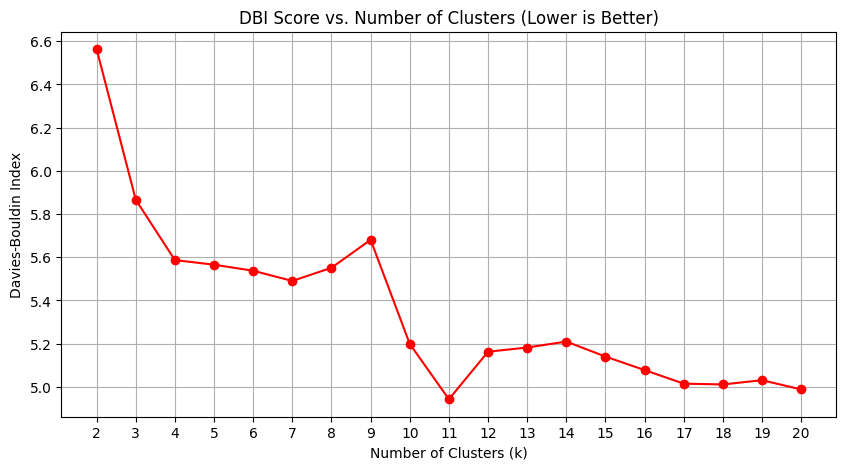


Optimal number of clusters found: 11
Clustering and PCA complete. Ready to visualize!


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import numpy as np

matrix = np.stack(df_final["embedding"].to_numpy())

print("Calculating DBI scores for k=2 to 20...")
scores = []
k_range = range(2, 21)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(matrix)
    score = davies_bouldin_score(matrix, labels)
    scores.append(score)
    print(f"k={k}: {score:.4f}", end=" | ")


plt.figure(figsize=(10, 5))
plt.plot(k_range, scores, marker='o', color='red')
plt.title("DBI Score vs. Number of Clusters (Lower is Better)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.grid(True)
plt.xticks(k_range)
plt.show()

best_k = k_range[np.argmin(scores)]
print(f"\nOptimal number of clusters found: {best_k}")


kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
df_final = df_final.with_columns(
    pl.Series("cluster", kmeans.fit_predict(matrix))
)

pca = PCA(n_components=2)
vis_dims = pca.fit_transform(matrix)
df_final = df_final.with_columns([
    pl.Series("x", vis_dims[:, 0]),
    pl.Series("y", vis_dims[:, 1])
])

print("Clustering and PCA complete. Ready to visualize!")

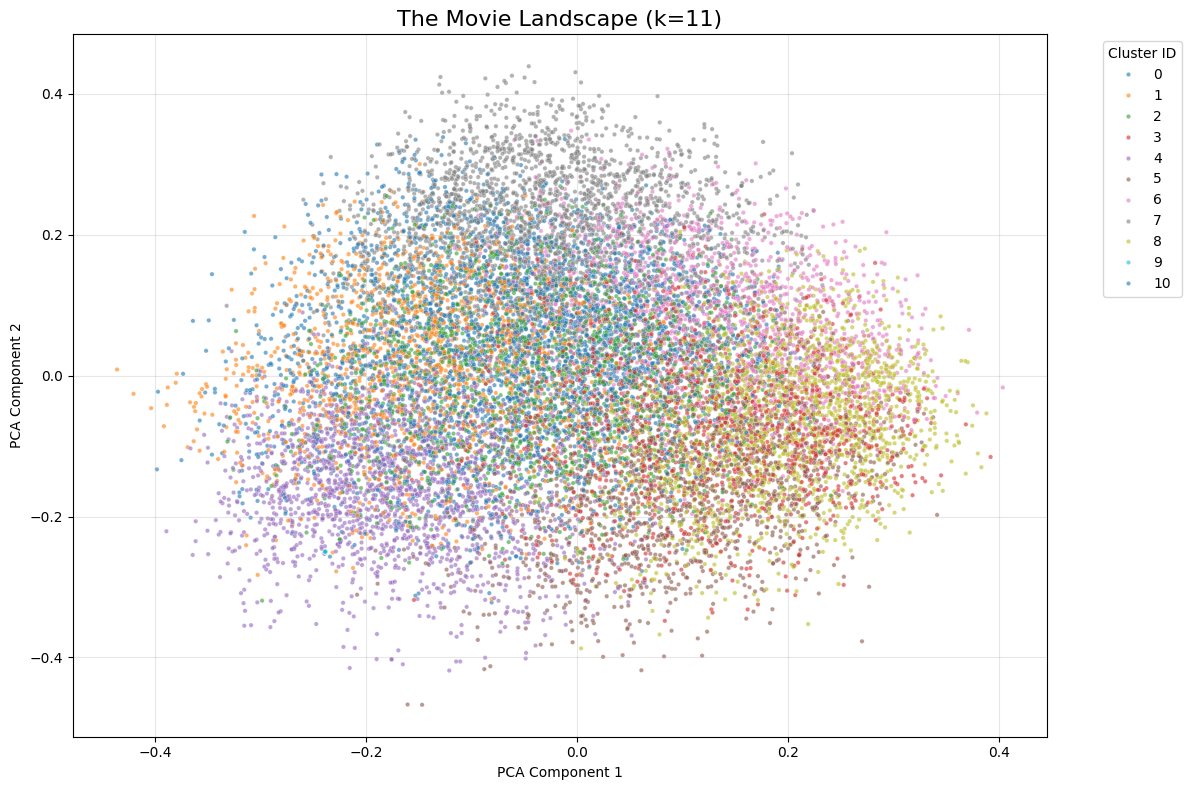

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_data = df_final.select(["x", "y", "cluster"]).to_pandas()

plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=plot_data,
    x="x", 
    y="y",
    hue="cluster",       
    palette="tab10",     
    s=10,                
    alpha=0.6,           
    legend="full"
)

plt.title(f"The Movie Landscape (k={best_k})", fontsize=16)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

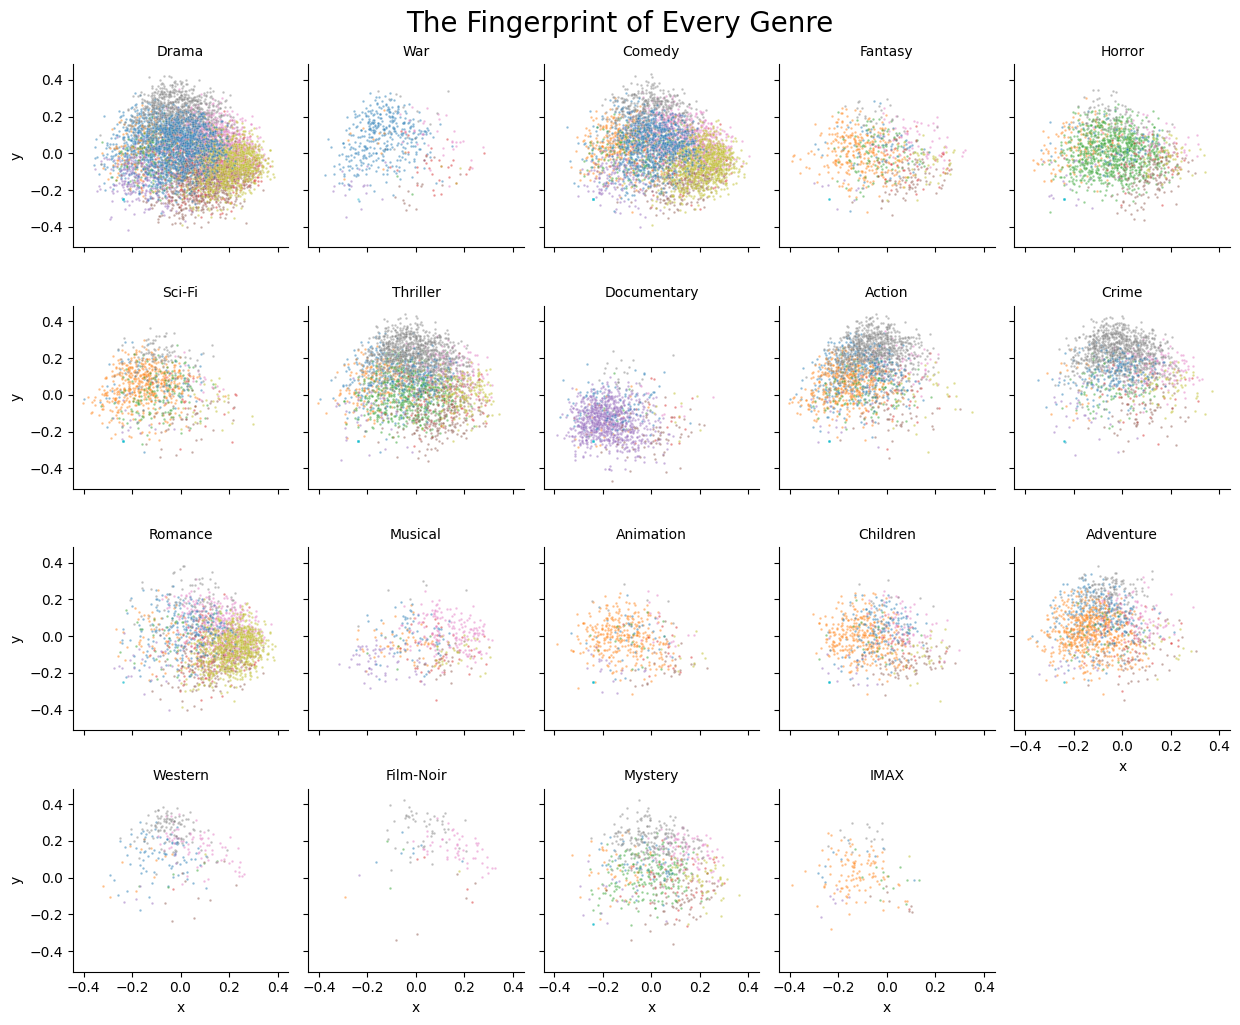

In [ ]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns


df_exploded = (
    df_final
    .select(["x", "y", "cluster", "lm_genre"]) 
    .with_columns(pl.col("lm_genre").str.split("|"))
    .explode("lm_genre")
    .filter(pl.col("lm_genre") != "(no genres listed)") 
    .filter(pl.col("lm_genre") != "Unknown")
)

pdf = df_exploded.to_pandas()


g = sns.FacetGrid(
    pdf, 
    col="lm_genre", 
    col_wrap=5,     
    hue="cluster",  
    palette="tab10", 
    height=2.5, 
    aspect=1
)

g.map(sns.scatterplot, "x", "y", s=3, alpha=0.5)
g.set_titles("{col_name}") 
g.fig.suptitle("The Fingerprint of Every Genre", y=1.02, fontsize=20)
plt.show()

In [ ]:
# Calculate Counts per Cluster + Genre
cluster_stats = (
    df_exploded
    .group_by(["cluster", "lm_genre"]) # <--- FIXED
    .count()
    .with_columns([
        pl.col("count").sum().over("cluster").alias("cluster_total"),
    ])
    .with_columns([
        (pl.col("count") / pl.col("cluster_total") * 100).alias("percentage")
    ])
    .sort(["cluster", "count"], descending=[False, True])
)


pivot_table = cluster_stats.pivot(
    index="cluster",
    columns="lm_genre", 
    values="percentage"
).fill_null(0) 

pd.set_option('display.max_columns', None) 
pd.set_option('display.float_format', '{:.1f}%'.format) 

print("--- CLUSTER COMPOSITION (Percentage of Genre Tags) ---")
print(pivot_table.to_pandas())

C:\Users\farim\AppData\Local\Temp\ipykernel_20600\3353788120.py:5: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()


--- CLUSTER COMPOSITION (Percentage of Genre Tags) ---
    cluster  Drama   War  Action  Thriller  Adventure  Comedy  Romance  \
0         0  29.4% 16.2%   13.6%     10.3%       8.5%    4.8%     3.4%   
1         1   6.0%  0.3%   12.0%      5.7%      15.1%   10.4%     1.8%   
2         2  11.2%  0.1%    4.1%     21.5%       1.3%    7.3%     1.7%   
3         3  39.1%  1.9%    2.4%      6.5%       3.2%   11.5%    15.7%   
4         4  18.1%  1.0%    1.2%      2.5%       1.1%    9.5%     1.7%   
5         5  36.5%  0.6%    2.1%     10.6%       2.4%   14.4%     8.2%   
6         6  26.2%  1.1%    2.1%      5.0%       2.8%   25.5%    12.9%   
7         7  18.7%  0.3%   16.1%     19.7%       2.9%    9.3%     1.8%   
8         8  28.9%  0.1%    1.0%      5.2%       0.7%   29.4%    24.6%   
9         9  14.2%  0.7%    4.5%      9.0%       1.5%   32.1%     1.5%   
10       10  35.4%  0.4%    4.1%      4.2%       3.1%   27.4%     5.5%   

    Western  Documentary  Crime  Sci-Fi  Horror  Mystery

C:\Users\farim\AppData\Local\Temp\ipykernel_20600\3353788120.py:17: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivot_table = cluster_stats.pivot(


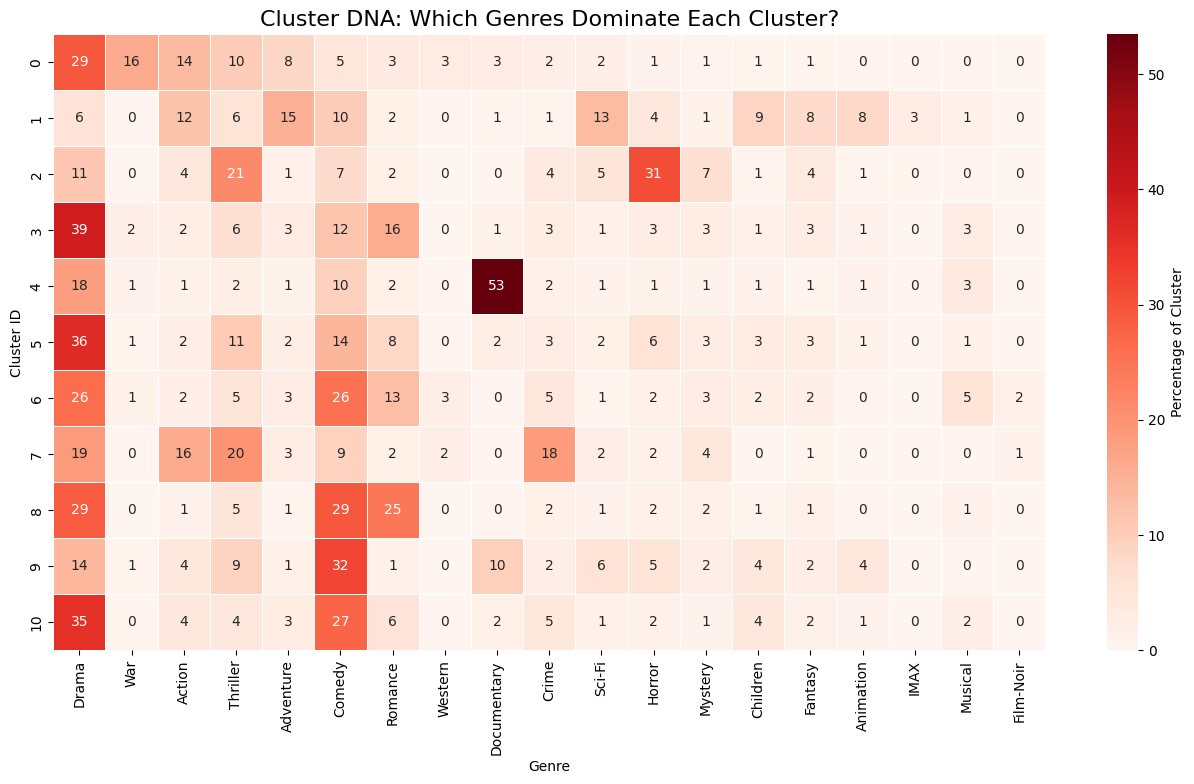

In [ ]:
# Convert to Pandas for Seaborn
pdf_pivot = pivot_table.to_pandas().set_index("cluster") # <--- FIXED

plt.figure(figsize=(16, 8))

# Draw Heatmap
sns.heatmap(
    pdf_pivot, 
    annot=True,       
    fmt=".0f",        
    cmap="Reds",      
    linewidths=.5,    
    cbar_kws={'label': 'Percentage of Cluster'}
)

plt.title("Cluster DNA: Which Genres Dominate Each Cluster?", fontsize=16)
plt.xlabel("Genre")
plt.ylabel("Cluster ID")
plt.show()

In [ ]:

genre_destinations = (
    df_exploded
    .group_by(["lm_genre", "cluster"])
    .count()
    .with_columns([
        pl.col("count").sum().over("lm_genre").alias("genre_total_count")
    ])
    .with_columns([
        (pl.col("count") / pl.col("genre_total_count") * 100).alias("percentage")
    ])
    .sort(["lm_genre", "percentage"], descending=[False, True])
)


pivot_genre_view = genre_destinations.pivot(
    index="lm_genre", 
    columns="cluster", 
    values="percentage"
).fill_null(0)


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.1f}%'.format)

print("--- GENRE DISTRIBUTION: Where does each genre live? ---")
print("(Rows sum to 100%)")
print(pivot_genre_view.to_pandas())

--- GENRE DISTRIBUTION: Where does each genre live? ---
(Rows sum to 100%)
       lm_genre     7     1     0     2    10     6     5     3     8     4  \
0        Action 38.4% 24.2% 14.9%  6.0%  5.9%  3.2%  2.6%  1.9%  1.6%  1.0%   
1     Adventure 10.6% 46.9% 14.4%  2.9%  6.9%  6.6%  4.4%  4.0%  1.6%  1.4%   
2     Animation  1.2% 68.2%  1.4%  3.7%  6.4%  3.1%  5.5%  3.5%  2.1%  3.7%   
3      Children  1.7% 47.4%  1.8%  2.8% 17.5%  9.6% 10.4%  2.8%  3.3%  2.0%   
4        Comedy 10.1%  9.6%  2.4%  5.0% 18.2% 17.6%  7.9%  4.2% 20.4%  3.7%   
5         Crime 57.4%  1.7%  3.0%  6.8%  8.8%  9.0%  4.5%  3.2%  3.7%  1.9%   
6   Documentary  1.6%  2.6%  4.9%  1.2%  4.6%  0.6%  5.0%  1.5%  0.7% 76.2%   
7         Drama 13.4%  3.7%  9.7%  5.0% 15.5% 12.0% 13.3%  9.4% 13.3%  4.6%   
8       Fantasy  3.3% 41.7%  1.7% 14.5%  6.5%  8.5%  9.8%  6.2%  6.1%  1.2%   
9     Film-Noir 40.3%  0.8%  3.2%  2.4%  2.4% 41.9%  4.0%  3.2%  0.8%  0.8%   
10       Horror  5.0% 10.7%  1.3% 59.5%  2.8%  3.3%  9.3

C:\Users\farim\AppData\Local\Temp\ipykernel_20600\1666123881.py:19: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()
C:\Users\farim\AppData\Local\Temp\ipykernel_20600\1666123881.py:30: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivot_genre_view = genre_destinations.pivot(


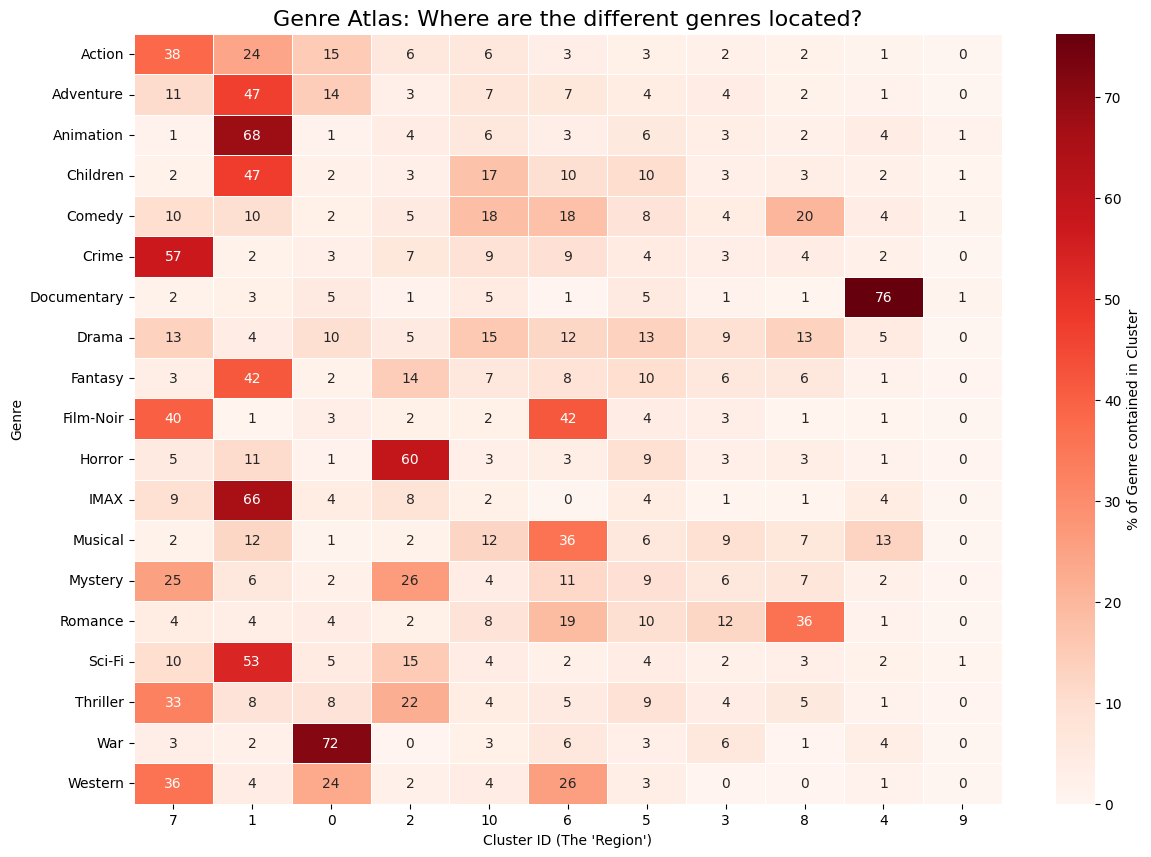

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

pdf_genre_map = pivot_genre_view.to_pandas().set_index("lm_genre")

plt.figure(figsize=(14, 10))

# Draw Heatmap
sns.heatmap(
    pdf_genre_map, 
    annot=True,       
    fmt=".0f",        
    cmap="Reds",      
    linewidths=.5,
    cbar_kws={'label': '% of Genre contained in Cluster'}
)

plt.title("Genre Atlas: Where are the different genres located?", fontsize=16)
plt.xlabel("Cluster ID (The 'Region')")
plt.ylabel("Genre")
plt.show()